### nevenborak@icloud.com
October 2022

# Function importing

In [1]:
import numpy as np
import pandas as pd

from glob import glob
from path import Path

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.multitest import multipletests

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 15}

mpl.rc('font', **font)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Function definitions

In [2]:
def reduce_pca(df, percentile=0.95):
    pca = PCA()
    pca.fit(df)

    kept_factors = (np.cumsum(pca.explained_variance_) < pca.explained_variance_.sum() * percentile).sum()

    df_pca = pca.transform(df)[:, :kept_factors]
    weights = pca.components_[:kept_factors]
    
    return df_pca, weights

# Data Loading

## Analysis parameters

In [ ]:
path = '/Volumes/proj-data-challenge/2022/proj-pedersen/curated/v1.0.0/'
remove_unknown_features = True

In [30]:
files = glob(f'{path}*.csv')
timepoint = 't1'

# Find data modalities
modalities = []
for file in files:
    file = Path(file)
    name = file.name
    name = name.split('_')[0]
    modalities.append(name)
    
modalities = np.unique(modalities)

# Prepare structured data variables
datas = {}
samples = {}
features = {}

scaler = StandardScaler()
accepted_modalities = []

feature_name_columns = {'metabolomics-polar': 'Name',
                        'metabolomics-apolar': 'Name',
                        'metagenomics': 'X.OTU.ID',
                        'proteomics-pellets': 'First.Proteinescription',
                        'proteomics-tissue': 'First.Proteinescription',
                        'rnaseq': 'symbol'}

# Load data and metadata
for modality in modalities:
    print(modality)
    
    # Only these datasets can be combined at the moment since they contain the same samples
    # The rnaseq and proteomics-tissue datasets can only be run individually
    if modality not in ['metabolomics-polar', 'metabolomics-apolar', 'metagenomics', 'proteomics-pellets']:
        continue
    
    if modality == 'rnaseq':
        time = ''
    else:
        time = 'all'
    
    
    # Extract dataset samples
    sample = pd.read_csv(glob(f'{path}{modality}*{time}*raw-sample*')[0])
    
    if modality in ['metabolomics-polar', 'metabolomics-apolar', 'metagenomics']:
        sample['Group_Disease'] = sample['Subject.ID'].str.startswith('V').fillna(0)
        sample = sample[['Time', 'Group_Disease', 'Subject.ID']]
        
    elif modality == 'proteomics-pellets':
        sample['Group_Disease'] = sample['Subject.ID'].str.startswith('V').fillna(0)
        sample = sample[['Timepoint', 'Group_Disease', 'Subject.ID']]
        sample = sample.rename(columns={'Timepoint': 'Time'})
        
    elif modality in ['proteomics-tissue', 'rnaseq']:
        sample['Group_Disease'] = sample['Subject.ID'].str.startswith('V').fillna(0)
        sample['Time'] = np.ones(sample.shape[0])
        sample = sample[['Time', 'Group_Disease', 'Subject.ID']]
    
    valid_samples = np.logical_and(sample['Time'] >= 0, ~sample['Subject.ID'].isnull())
    
    sample = sample[valid_samples].reset_index(drop=True)
    sample_order = np.argsort(sample['Time'].astype(str) + sample['Subject.ID'])
    sample = sample.loc[sample_order].reset_index(drop=True)
    samples[modality] = sample
    

    # Extract dataset features
    feature = pd.read_csv(glob(f'{path}{modality}*{time}*raw-feature*')[0])
    feature = feature[feature_name_columns[modality]]
    
    # Map ASV codes to taxonomic names for metagenomics features
    if modality == 'metagenomics':
        mtg_names = pd.read_csv('/Volumes/proj-data-challenge/2022/proj-pedersen/Metagenomics/metagenomics_taxonomy.csv')
        mtg_names = dict(zip(mtg_names.ASV_ID, mtg_names.Order + ' / ' + mtg_names.Family + ' / ' + mtg_names.Genus))
        feature = pd.DataFrame([mtg_names[key] for key in feature], columns=['Name'])['Name']

    if remove_unknown_features:
        valid_features = ~feature.isnull()
    else:
        valid_features = np.ones(feature.shape[0], dtype=bool)
    
    feature = feature[valid_features].reset_index(drop=True)
    features[modality] = feature
    
    # Load and preprocess data
    data = pd.read_csv(glob(f'{path}{modality}*{time}*raw-data*')[0])
    data = np.array(data)[:, 1:].T
    data = data[valid_samples][:, valid_features]
    data = data[sample_order]
    #data = scaler.fit_transform(data)
    datas[modality] = data
    
    accepted_modalities.append(modality)
    
modalities = accepted_modalities


metabolomics-apolar
metabolomics-polar
metagenomics
proteomics-pellets
proteomics-tissue
rnaseq


# PCA of each dataset

In [43]:
weights = {}
data_latent = {}
num_comps = {}

for modality in modalities:
    print(modality)
    
    data = datas[modality]
    data = scaler.fit_transform(data)
    
    # Impute nan values
    data[np.isnan(data)] = 0
    
    data_pca, weight = reduce_pca(data, 0.80)
    
    weights[modality] = weight
    data_latent[modality] = data_pca
    
    num_comps[modality] = data_pca.shape[1]
    

metabolomics-apolar
metabolomics-polar
metagenomics
proteomics-pellets


# Fit linear model

Best cross-validated model performance 0.9941176470588236
Multicolinearity score between selected latents: 7.014116903836875


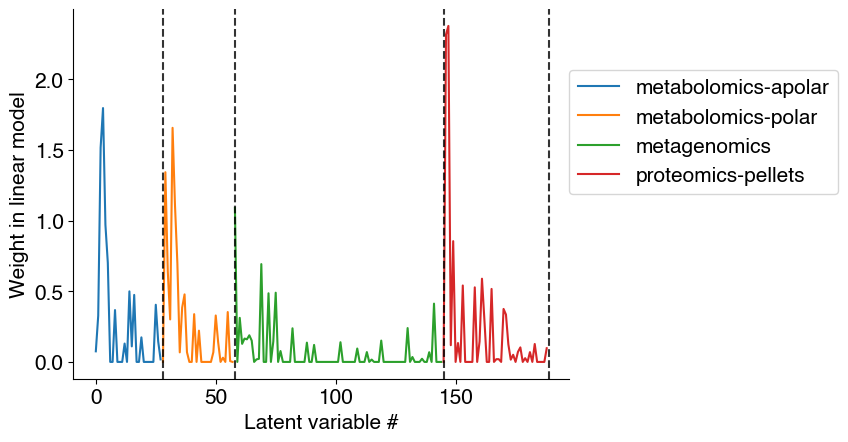

In [12]:
multiome = np.hstack(list(data_latent.values()))

multiome = scaler.fit_transform(multiome)

labels = np.array(list(samples.values())[0][['Time', 'Group_Disease']].sum(axis=1) == 2, dtype=int)
#labels = np.array(samples['metabolomics-apolar']['Group_Disease']).astype(int)

model = LogisticRegressionCV(solver='liblinear', penalty='l1', Cs=[0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000], cv=10)
model.fit(multiome, labels)
print(f'Best cross-validated model performance {model.scores_[1][:, np.where(model.Cs_ == model.C_)[0]].mean()}')

linmodel_weights = np.abs(model.coef_[0])
useful_latents = np.where(linmodel_weights > linmodel_weights.max() * 0)[0]

bounds = np.insert((np.cumsum(list(num_comps.values()))), 0, 0)
bounds = zip(bounds[:-1], bounds[1:])


for n, bound in enumerate(bounds):
    
    start, stop = bound

    plt.plot(np.arange(start, stop), linmodel_weights[start:stop], label=modalities[n])

for line in np.cumsum(list(num_comps.values())):
    plt.axvline(line, c='black', linestyle='--', alpha=0.8)
    
plt.legend(loc=[1, 0.5])
plt.ylabel('Weight in linear model')
plt.xlabel('Latent variable #')

mc_score = VIF(multiome[:, useful_latents], 0)
print(f'Multicolinearity score between selected latents: {mc_score}')

#plt.savefig('/Users/borakn/Desktop/Latent weights.png', dpi=300, bbox_inches='tight')

# Identify the original features that contribute to the useful latents

In [13]:
model_feature_weights = {}

previous = 0
for modality in modalities:
    
    modality_latent_idx = useful_latents[np.logical_and(useful_latents > previous, useful_latents < previous + num_comps[modality])]
    
    modality_useful_latents = modality_latent_idx - previous
    modality_latent_weights = linmodel_weights[modality_latent_idx]
    feature_weights = (weights[modality][modality_useful_latents].T * modality_latent_weights).T
    model_feature_weights[modality] = np.abs(feature_weights).sum(axis=0)

    previous+= num_comps[modality]

## Visualise feature weight distribution by modality

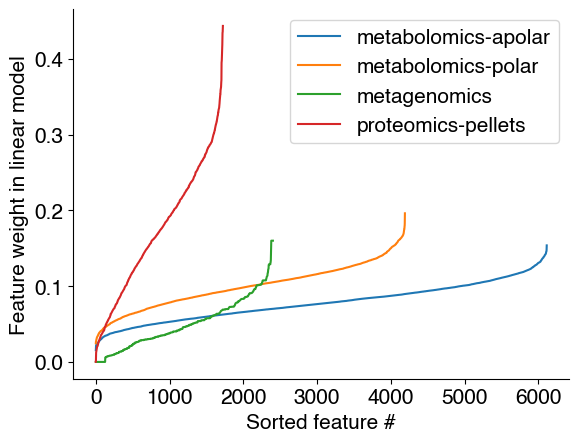

In [14]:
for modality in modalities:

    plt.plot(np.sort(model_feature_weights[modality]), label=modality)

plt.xlabel('Sorted feature #')
plt.ylabel('Feature weight in linear model')

plt.legend()

#plt.savefig('/Users/borakn/Desktop/Feature weights.png', dpi=300, bbox_inches='tight')

## Extracting IDs of candidate biomarkers

In [19]:
select_top_N = 20

candidate_biomarkers = {}
selected_datas = {}

candidate_idxs = {}
for modality in modalities:
    
    candidate_idx = np.argpartition(model_feature_weights[modality], -select_top_N)[-select_top_N:]
    candidate_idxs[modality] = candidate_idx
    candidate_biomarkers[modality] = features[modality].loc[candidate_idx]
    candidate_biomarkers[modality] = ['_'.join(['ID', str(n)]) for n in np.arange(select_top_N)]
    
    selected_datas[modality] = datas[modality][:, candidate_idx]
    
stacked_feature_names = np.concatenate(list(candidate_biomarkers.values()))

known_compounds = ~(stacked_feature_names.astype(str) == 'nan')


## Visualise weights of top features from each modality

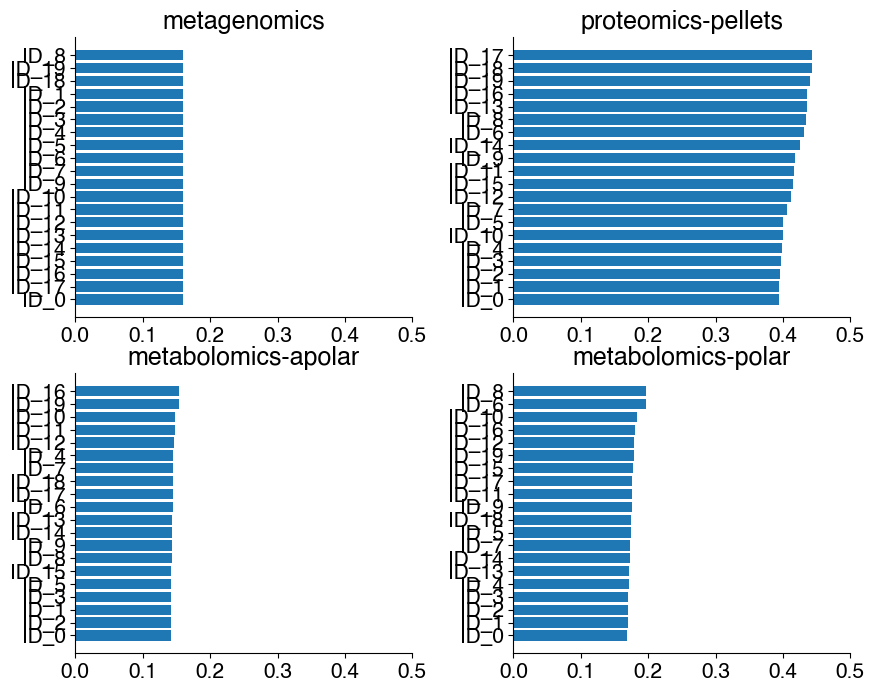

In [24]:
plt.figure(figsize=[10,8])

modalities_plots = np.roll(modalities, 2)

for n, modality in enumerate(modalities_plots):
    plt.subplot(2,2, n+1)

    order = np.argsort(model_feature_weights[modality][candidate_idxs[modality]])
    plt.barh(np.arange(len(candidate_biomarkers[modality])), model_feature_weights[modality][candidate_idxs[modality]][order])

    plt.yticks(ticks=np.arange(len(candidate_biomarkers[modality])), labels=np.array(candidate_biomarkers[modality])[order])
    
    plt.xlim(0, 0.5)
    
    plt.title(modality)
    
plt.subplots_adjust(wspace=0.3,
                    hspace=0.2)

#plt.savefig('/Users/borakn/Desktop/Final candidates.png', dpi=300, bbox_inches='tight')

## Visualise differences in biomarker amounts

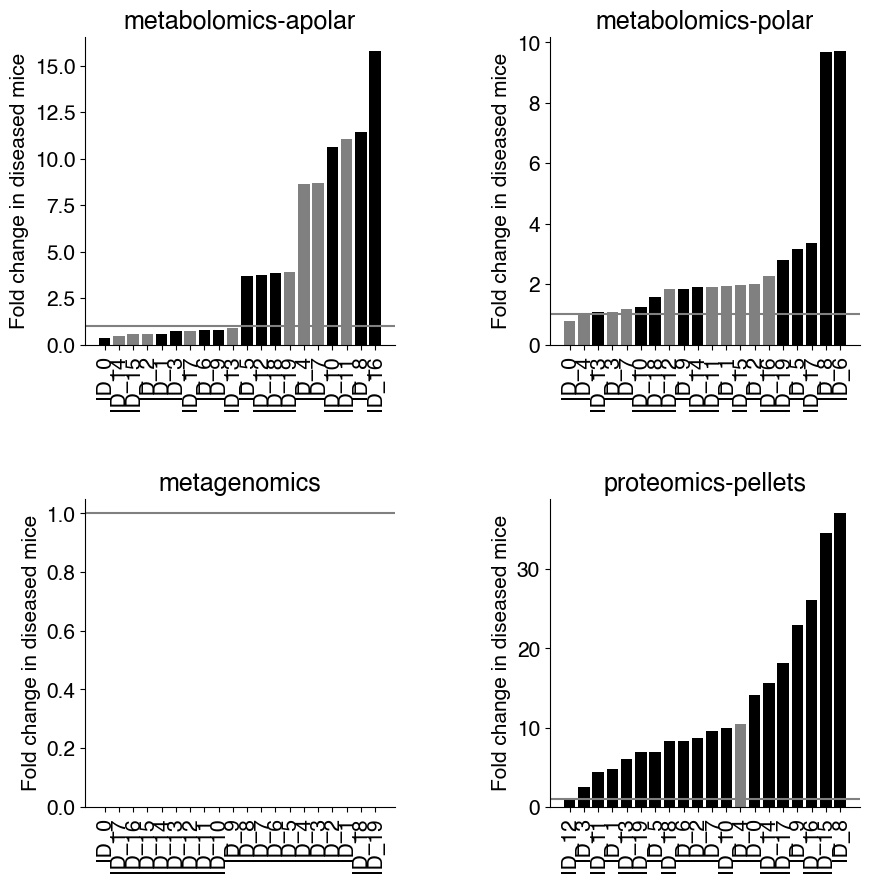

In [42]:
color_mapping = {True: 'black',
                 False: 'grey'}

correction_method = 'bonferroni'

plt.figure(figsize=[10,10])
for n, modality in enumerate(modalities):
    
    plt.subplot(2, 2, n+1)

    data_health = datas[modality][labels == 0][:, candidate_idxs[modality]]
    data_disease = datas[modality][labels == 1][:, candidate_idxs[modality]]

    p_vals = stats.ttest_ind(data_health, data_disease, axis=0, nan_policy='omit')[1]
    significant = multipletests(p_vals, alpha=0.05, method=correction_method)[0]

    colors = [color_mapping[sig] for sig in significant]
    
    data_health = np.nanmean(data_health, axis=0)
    data_disease = np.nanmean(data_disease, axis=0)

    differential_expression = data_disease / data_health

    order = np.argsort(differential_expression)

    plt.bar(np.arange(len(differential_expression)), differential_expression[order], color=colors)
    _ = plt.xticks(np.arange(len(differential_expression)), np.array(candidate_biomarkers[modality])[order], rotation=90)

    plt.axhline(1, c='grey')
    plt.ylabel('Fold change in diseased mice')
    plt.title(modality)
    
plt.subplots_adjust(hspace=0.5, wspace=0.5)